In [12]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Function to calculate first differences
def calculate_first_difference(df, year_columns):
    df_first_diff = df[year_columns].diff(axis=1)
    df_first_diff.drop(year_columns[0], axis=1, inplace=True)
    return df_first_diff

# Load all datasets
temperature_change_df = pd.read_csv('Annual_Surface_Temperature_Change.csv')
disasters_frequency_df = pd.read_csv('Climate-related_Disasters_Frequency.csv')
land_cover_df = pd.read_csv('Land_Cover_Accounts.csv')
forest_carbon_df = pd.read_csv('Forest_and_Carbon.csv')

In [13]:
# Calculate first differences for temperature data
year_columns_temperature = [col for col in temperature_change_df.columns if col.startswith('F')]
temperature_change_first_diff_df = calculate_first_difference(temperature_change_df, year_columns_temperature)
temperature_change_df[year_columns_temperature[1:]] = temperature_change_first_diff_df

In [14]:
# Load the file containing the ISO Alpha-3 codes and the corresponding regions
country_continent_df = pd.read_csv('all.csv')

# Let's take a look at the contents of the file to understand its structure
country_continent_df.head()

# Create a mapping dictionary from the 'alpha-3' codes to the 'region'
region_mapping = dict(zip(country_continent_df['alpha-3'], country_continent_df['region']))

# Define a function to map each dataset's ISO3 codes to the corresponding region
def map_iso3_to_region(df):
    # Add a 'Region' column based on the 'ISO3' column and the region mapping
    df['Region'] = df['ISO3'].map(region_mapping)
    # Drop any rows that do not have a region mapping (if any)
    df = df.dropna(subset=['Region'])
    return df

# Apply the region mapping to each of the datasets
temperature_change_df = map_iso3_to_region(temperature_change_df)
disasters_frequency_df = map_iso3_to_region(disasters_frequency_df)
land_cover_df = map_iso3_to_region(land_cover_df)
forest_carbon_df = map_iso3_to_region(forest_carbon_df)

# Function to preprocess temperature_change_df and create a 'Year' column
def preprocess_temperature_change(df):
    # Extract columns that start with 'F', which represent years
    year_columns = [col for col in df.columns if col.startswith('F')]
    # Melt the dataframe to long format with 'Year' and 'Temperature_Change'
    df_long = df.melt(id_vars=['ISO3'], value_vars=year_columns, var_name='Year', value_name='Temperature_Change')
    # Convert 'Year' from 'FYYYY' to 'YYYY' format and cast to integer
    df_long['Year'] = df_long['Year'].str.replace('F', '').astype(int)
    # Map the 'Region' based on the 'ISO3' code
    df_long['Region'] = df_long['ISO3'].map(region_mapping)
    # Group by 'Region' and 'Year', calculate the mean, and reset the index
    df_grouped = df_long.groupby(['Region', 'Year']).mean().reset_index()
    return df_grouped

# Apply preprocessing to the temperature change data
temperature_change_grouped = preprocess_temperature_change(temperature_change_df)

# To include the "Indicator" column, we will modify the clean_and_melt function to keep this column.
# Then, we will apply the modified function to the datasets.

def clean_melt_and_map(df, value_name, indicator_column='Indicator'):
    # Keep only necessary columns: ISO3, Indicator, and years
    df = df[['ISO3', indicator_column] + [col for col in df if col.startswith('F')]]

    # Rename the columns to remove 'F' from the year columns
    df.columns = [col.replace('F', '') if col.startswith('F') else col for col in df.columns]

    # Convert the dataframe to long format
    df_long = df.melt(id_vars=['ISO3', indicator_column], var_name='Year', value_name=value_name)

    # Convert Year to integer and sort the dataframe
    df_long['Year'] = df_long['Year'].astype(int)
    df_long = df_long.sort_values(by=['ISO3', 'Year'])

    # Map the ISO3 codes to the region using the previously created region mapping
    df_long['Region'] = df_long['ISO3'].map(region_mapping)

    # Drop any rows that have NaN in the 'Region' column
    df_long = df_long.dropna(subset=['Region'])

    return df_long

# Clean, convert, and map the land cover, forest carbon, and disasters frequency datasets
land_cover_long_df = clean_melt_and_map(land_cover_df, 'Land_Cover')
forest_carbon_long_df = clean_melt_and_map(forest_carbon_df, 'Forest_Carbon')
disasters_frequency_long_df = clean_melt_and_map(disasters_frequency_df, 'Disasters_Frequency')

# Display the first few rows of each cleaned and long format dataframe with "Indicator"
# (land_cover_long_df.head(), forest_carbon_long_df.head(), disasters_frequency_long_df.head())
land_cover_long_df.head()

<ipython-input-14-2847a4057d4c>:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df_long.groupby(['Region', 'Year']).mean().reset_index()


,ISO3,Indicator,Year,Land_Cover,Region
12,ABW,Climate Altering Land Cover Index,1992,32.330518,Americas
350,ABW,Artificial surfaces (including urban and assoc...,1992,0.133700,Americas
351,ABW,Grassland,1992,2.982400,Americas
352,ABW,Herbaceous crops,1992,0.574500,Americas
353,ABW,Inland water bodies,1992,0.767300,Americas


In [15]:
# Function to find the union of all indicators
def find_union_indicators(df):
    # Group by country and collect unique indicators for each country
    indicators_by_country = df.groupby('ISO3')['Indicator'].unique()
    # Find the union of all sets of indicators
    all_indicators = set().union(*indicators_by_country)
    return list(all_indicators)

# Find the union of indicators for each dataset
union_land_cover_indicators = find_union_indicators(land_cover_long_df)
union_forest_carbon_indicators = find_union_indicators(forest_carbon_long_df)
union_disasters_frequency_indicators = find_union_indicators(disasters_frequency_long_df)

# Now pivot the dataframes using the common set of indicators
def pivot_dataframe_with_common_indicators(long_df, value_name, common_indicators):
    pivoted_df = long_df.pivot_table(
        index=['ISO3', 'Year'],
        columns='Indicator',
        values=value_name,
        aggfunc='first'
    ).reset_index()

    # Filter the pivoted dataframe to only include common indicators
    pivoted_df = pivoted_df[['ISO3', 'Year'] + common_indicators]

    # Rename columns to remove the MultiIndex
    pivoted_df.columns.name = None

    return pivoted_df

# Pivot the dataframes using the union of all indicators
land_cover_pivoted_union_df = pivot_dataframe_with_common_indicators(
    land_cover_long_df, 'Land_Cover', union_land_cover_indicators
)
forest_carbon_pivoted_union_df = pivot_dataframe_with_common_indicators(
    forest_carbon_long_df, 'Forest_Carbon', union_forest_carbon_indicators
)
disasters_frequency_pivoted_union_df = pivot_dataframe_with_common_indicators(
    disasters_frequency_long_df, 'Disasters_Frequency', union_disasters_frequency_indicators
)


In [16]:
# Function to add the region column to a dataframe and perform the necessary fill operations
# Modify the add_region_and_fill function to handle the 'Region' ambiguity and ensure 'Region' is only a column
def add_region_and_fill_corrected(df, region_mapping, fill_strategy='interpolate'):
    # Map the 'Region' based on the 'ISO3' code
    df['Region'] = df['ISO3'].map(region_mapping)

    # If the fill strategy is interpolation, perform it within each group
    if fill_strategy == 'interpolate':
        # Perform linear interpolation with group_keys=True to avoid future behavior change
        df = df.groupby(['Region', 'Year'], group_keys=False).apply(
            lambda group: group.interpolate(method='linear', limit_direction='both'))
    elif fill_strategy == 'zero':
        # Fill NaN values with 0
        df.fillna(0, inplace=True)

    # Drop rows where 'Region' is NaN (no mapping found)
    df.dropna(subset=['Region'], inplace=True)

    return df

# Reapply the function to each dataframe with the corrected parameters
land_cover_pivoted_union_df = add_region_and_fill_corrected(land_cover_pivoted_union_df, region_mapping, 'interpolate')
forest_carbon_pivoted_union_df = add_region_and_fill_corrected(forest_carbon_pivoted_union_df, region_mapping, 'interpolate')
disasters_frequency_pivoted_union_df = add_region_and_fill_corrected(disasters_frequency_pivoted_union_df, region_mapping, 'zero')

# Group by Region and Year, then calculate the mean with numeric_only=True to avoid future behavior change
land_cover_grouped = land_cover_pivoted_union_df.groupby(['Region', 'Year']).mean(numeric_only=True).reset_index()
forest_carbon_grouped = forest_carbon_pivoted_union_df.groupby(['Region', 'Year']).mean(numeric_only=True).reset_index()
disasters_frequency_grouped = disasters_frequency_pivoted_union_df.groupby(['Region', 'Year']).mean(numeric_only=True).reset_index()

# Display the grouped dataframes
land_cover_grouped[land_cover_grouped['Region'] == 'Asia']
forest_carbon_grouped[forest_carbon_grouped['Region'] == 'Asia']
disasters_frequency_grouped[disasters_frequency_grouped['Region'] == 'Asia']


,Region,Year,"Climate related disasters frequency, Number of Disasters: Drought","Climate related disasters frequency, Number of Disasters: Storm","Climate related disasters frequency, Number of Disasters: TOTAL","Climate related disasters frequency, Number of Disasters: Landslide","Climate related disasters frequency, Number of Disasters: Wildfire","Climate related disasters frequency, Number of Disasters: Extreme temperature","Climate related disasters frequency, Number of Disasters: Flood"
86,Asia,1980,0.133333,1.266667,3.066667,0.200000,0.000000,0.133333,1.333333
87,Asia,1981,0.111111,1.500000,3.055556,0.222222,0.111111,0.055556,1.055556
88,Asia,1982,0.266667,1.466667,3.600000,0.333333,0.066667,0.066667,1.400000
89,Asia,1983,0.187500,1.687500,3.562500,0.437500,0.062500,0.000000,1.187500
90,Asia,1984,0.066667,0.666667,2.666667,0.200000,0.066667,0.066667,1.600000
91,Asia,1985,0.071429,1.285714,3.428571,0.071429,0.071429,0.142857,1.785714
92,Asia,1986,0.058824,1.882353,3.529412,0.294118,0.058824,0.058824,1.176471
93,Asia,1987,0.304348,0.956522,2.869565,0.086957,0.043478,0.130435,1.347826
94,Asia,1988,0.166667,1.111111,3.222222,0.555556,0.000000,0.111111,1.277778
95,Asia,1989,0.066667,1.866667,3.600000,0.533333,0.000000,0.266667,0.866667


In [17]:
# Apply the preprocessing function to temperature_change_df
temperature_change_grouped = preprocess_temperature_change(temperature_change_df)

# Identify the common range of years across all dataframes
common_years = set(temperature_change_grouped['Year']) & set(land_cover_grouped['Year']) & \
               set(forest_carbon_grouped['Year']) & set(disasters_frequency_grouped['Year'])

# Filter each grouped dataframe to only include the common years
temperature_change_grouped_common = temperature_change_grouped[temperature_change_grouped['Year'].isin(common_years)]
land_cover_grouped_common = land_cover_grouped[land_cover_grouped['Year'].isin(common_years)]
forest_carbon_grouped_common = forest_carbon_grouped[forest_carbon_grouped['Year'].isin(common_years)]
disasters_frequency_grouped_common = disasters_frequency_grouped[disasters_frequency_grouped['Year'].isin(common_years)]

# Merge the dataframes on 'Region' and 'Year'
merged_df = temperature_change_grouped_common.merge(land_cover_grouped_common, on=['Region', 'Year'], how='inner') \
    .merge(forest_carbon_grouped_common, on=['Region', 'Year'], how='inner') \
    .merge(disasters_frequency_grouped_common, on=['Region', 'Year'], how='inner')

# Display the merged dataframe
merged_df.head()

merged_df.to_csv('merged_dataframe.csv', index=False)

<ipython-input-14-2847a4057d4c>:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df_long.groupby(['Region', 'Year']).mean().reset_index()


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split the data while keeping 'Region' and 'Year' separate
X = merged_df.drop(['Year', 'Region', 'Temperature_Change'], axis=1)
y = merged_df['Temperature_Change']
regions = merged_df['Region']
years = merged_df['Year']

# Now split the data into training and testing sets, keeping the regions aligned
X_train, X_test, y_train, y_test, regions_train, regions_test, years_train, years_test = train_test_split(
    X, y, regions, years, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train the SVR model
svr_model = SVR(kernel='rbf', C=10, epsilon=0.1, gamma='scale')
svr_model.fit(X_train_pca, y_train)

# Make predictions
y_pred = svr_model.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Combine the regions, years, actual and predicted temperatures into a single DataFrame
results_df = pd.DataFrame({
    'Region': regions_test.values,
    'Year': years_test.values,
    'Actual': y_test.values,
    'Predicted': y_pred
})

# Compute performance metrics for each continent
metrics = {'Region': [], 'MSE': [], 'MAE': [], 'R2': []}

for region in results_df['Region'].unique():
    region_df = results_df[results_df['Region'] == region]
    mse = mean_squared_error(region_df['Actual'], region_df['Predicted'])
    mae = mean_absolute_error(region_df['Actual'], region_df['Predicted'])
    r2 = r2_score(region_df['Actual'], region_df['Predicted'])

    metrics['Region'].append(region)
    metrics['MSE'].append(mse)
    metrics['MAE'].append(mae)
    metrics['R2'].append(r2)

# Convert the metrics dictionary into a DataFrame
performance_df = pd.DataFrame(metrics)
performance_df

Mean Squared Error: 0.15104516047746527
Mean Absolute Error: 0.3246664081187213
R-squared: -0.9934815384381239


,Region,MSE,MAE,R2
0,Asia,0.176600,0.327331,-0.597295
1,Oceania,0.074108,0.214261,-0.695588
2,Africa,0.113568,0.312003,-0.253231
3,Americas,0.155222,0.337147,-0.971710
4,Europe,0.229482,0.430479,-4.443085


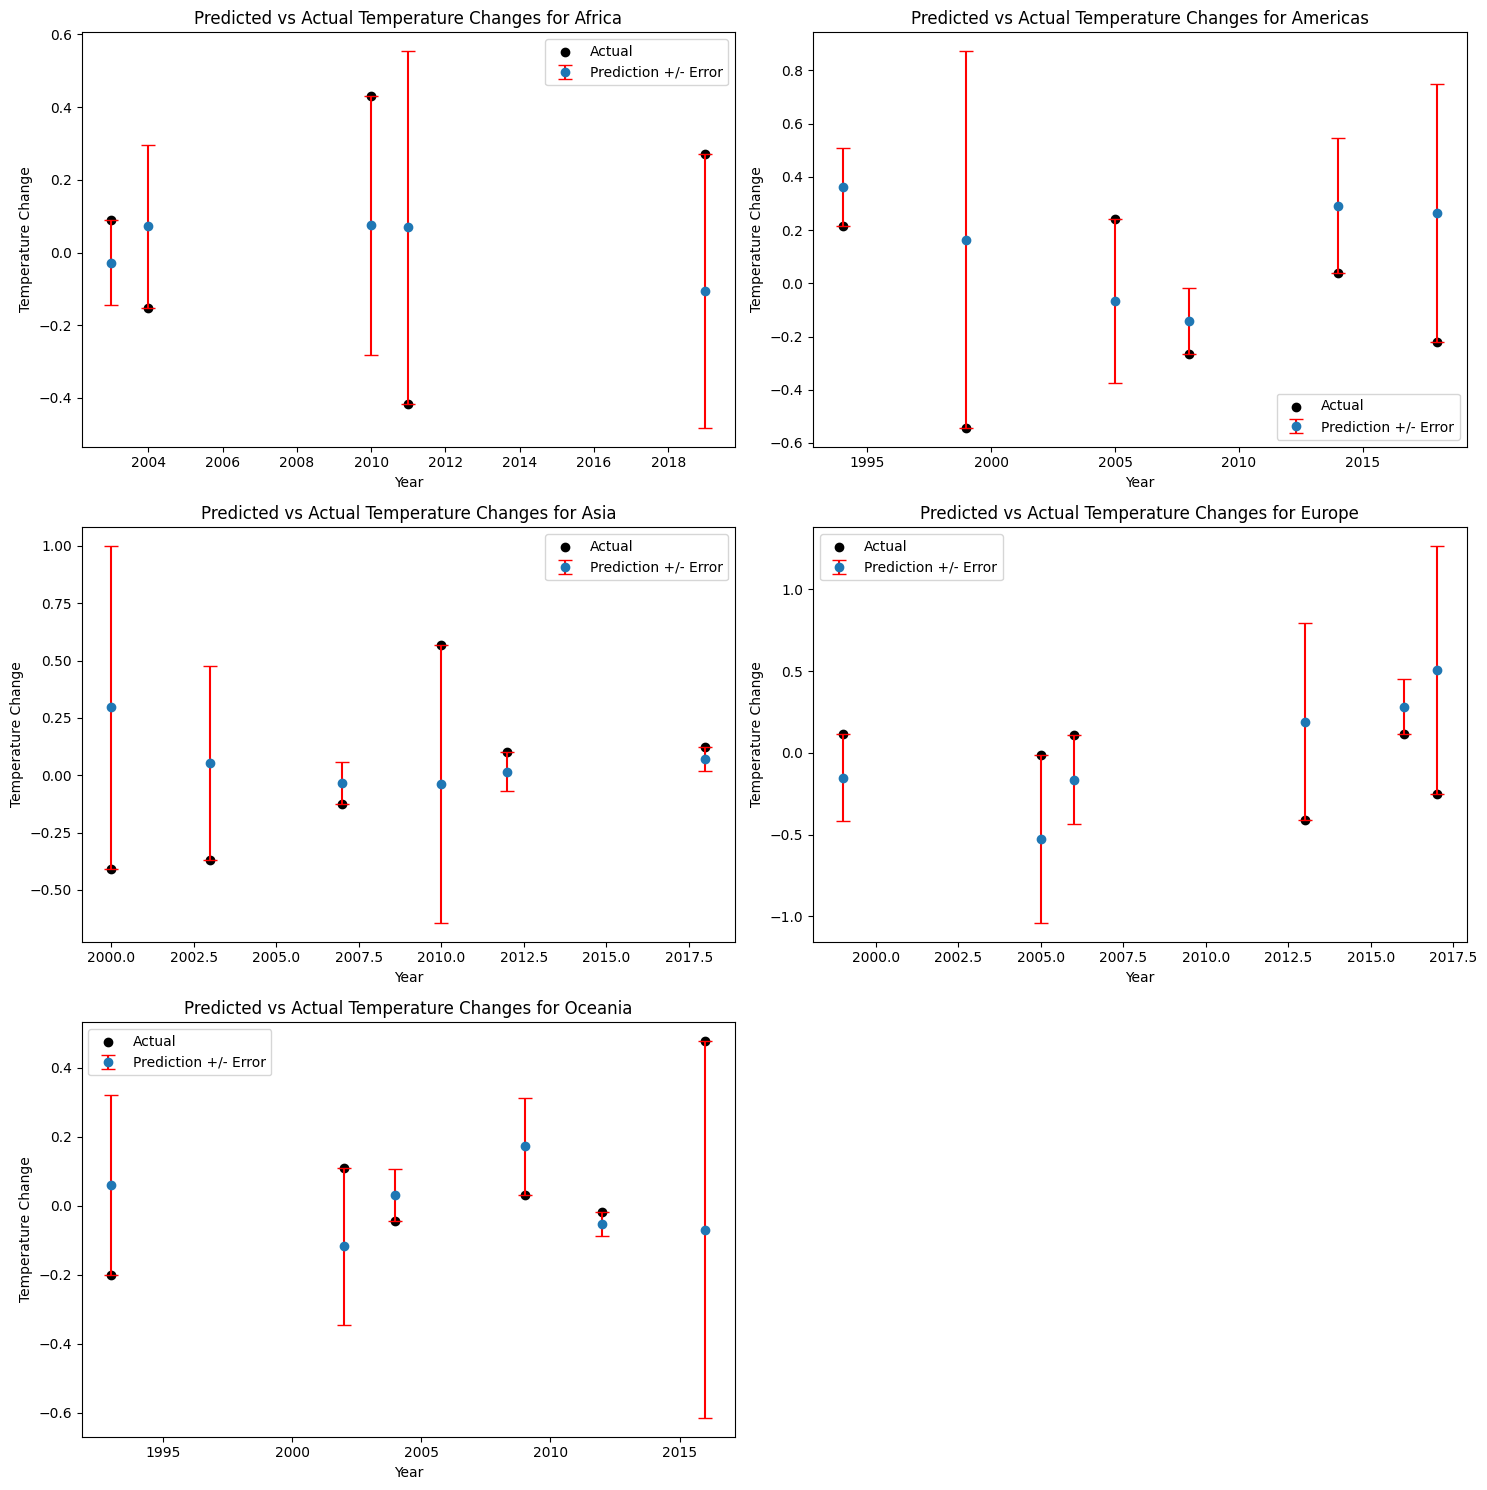

In [19]:
results_df['Error'] = results_df['Actual'] - results_df['Predicted']
results_df.to_csv('results.csv', index=False)

# Create a figure with subplots arranged in a 3x2 grid
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # Adjust the figsize as needed

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Filter unique regions and sort them for consistent plotting
unique_regions = sorted(results_df['Region'].unique())

for i, region in enumerate(unique_regions):
    region_df = results_df[results_df['Region'] == region]
    # Plotting on the ith subplot
    axs[i].errorbar(region_df['Year'], region_df['Predicted'], yerr=region_df['Error'].abs(), fmt='o', ecolor='red', capsize=5, label='Prediction +/- Error')
    axs[i].scatter(region_df['Year'], region_df['Actual'], color='black', label='Actual')
    axs[i].set_title(f'Predicted vs Actual Temperature Changes for {region}')
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Temperature Change')
    axs[i].legend()

# Hide the last (6th) subplot since we only have 5 regions
if len(unique_regions) < 6:
    fig.delaxes(axs[-1])  # Remove the last subplot if not needed

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('combined_temperature_change_plot.png')
plt.show()

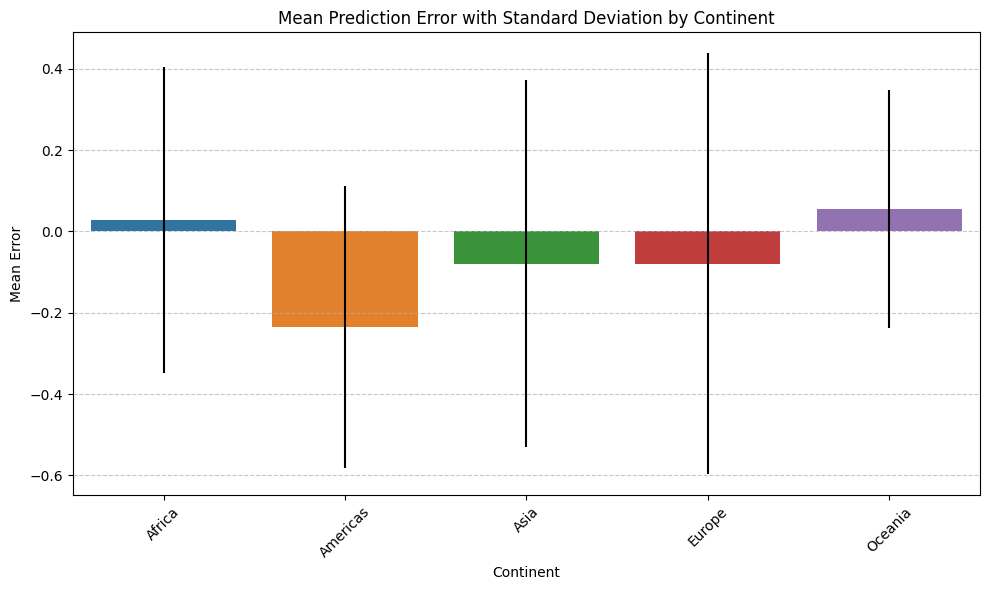

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by 'Region' and calculate the mean and standard deviation of the 'Error'
error_stats = results_df.groupby('Region')['Error'].agg(['mean', 'std']).reset_index()

# Create a bar plot with error bars
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='mean', yerr=error_stats['std'], data=error_stats, capsize=.1)
plt.title('Mean Prediction Error with Standard Deviation by Continent')
plt.xlabel('Continent')
plt.ylabel('Mean Error')
plt.xticks(rotation=45)  # Rotate the x labels to make them readable
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap

# Show the plot
plt.show()


In [21]:
y_pred

array([ 0.05438107, -0.06930943, -0.1058135 ,  0.06909619, -0.06729176,
        0.05954866, -0.1180249 ,  0.19071596,  0.07196785,  0.07478734,
        0.07210147,  0.26468256,  0.03130296,  0.01621109, -0.03317873,
        0.16450384,  0.50600114,  0.17164346, -0.52536028, -0.16334657,
       -0.15053648, -0.05285972, -0.02760895,  0.29615092,  0.36219554,
       -0.14097189,  0.29212241, -0.03864955,  0.28203268])